# 主題：政治新聞資料分析
- 組員：王冠人、萬俊彥、廖品琪
- 時間：2019/01/29

## 研究目標
考量臺灣社會政治冷感的現狀，提供一個較為客觀的資料統整，藉由日常生活中的事件觀察政治人物的網路聲量變化，作為一種參與政治的方式。

## 研究方法
1. 爬蟲搜尋網路新聞
2. 進行資料清理及資料分析
4. 視覺化呈現研究結果

## 研究內容及結果

# Part I 爬蟲

- [新頭殼新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/new_talk_crawler.ipynb)
- [自由時報新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/liberty_times_crawler.ipynb)

#  Part II 資料清洗及分析

In [5]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *

font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### 載入新聞資料

In [8]:
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1] # data element reverse
contents = [news['content'] for news in data] 

In [32]:
'''try demo the text analysis'''
cat = ' '.join(contents[:2])
cat = remove_punctuation(cat)
cutted = jieba.lcut(cat)
dict_cutted = lcut_to_dict(cutted)
dict_cutted

{'國民黨': 1,
 '新北市長侯友宜': 1,
 '今': 2,
 '日': 1,
 '一早': 1,
 '精神': 1,
 '奕奕': 1,
 '穿著': 1,
 '整套': 1,
 '騎車': 1,
 '裝': 1,
 '五名': 1,
 '年輕': 1,
 '同仁': 2,
 '陪伴': 1,
 '下': 1,
 '石門': 2,
 '麟山': 1,
 '鼻到': 1,
 '三芝': 2,
 '淺水灣': 2,
 '自行車道': 2,
 '欣賞': 1,
 '碧海': 1,
 '藍天': 1,
 '美景': 2,
 '風光': 1,
 '氣溫': 1,
 '超過': 1,
 '37': 1,
 '度': 2,
 '高溫': 1,
 '\x15': 1,
 '平常': 1,
 '運動': 1,
 '習慣': 1,
 '侯友宜': 6,
 '輕輕鬆鬆': 1,
 '完騎': 1,
 '七': 1,
 '公里': 1,
 '還笑': 1,
 '稱': 1,
 '小': 1,
 '北海岸': 2,
 '金山': 1,
 '萬里': 1,
 '皇冠': 1,
 '海岸': 2,
 '上': 1,
 '四顆': 1,
 '鑽石': 1,
 '未來': 2,
 '當選': 1,
 '新北市長': 1,
 '會': 4,
 '打造': 1,
 '更': 2,
 '完整': 1,
 '觀光': 1,
 '線': 1,
 '延伸': 1,
 '並與': 1,
 '淡水': 1,
 '串聯': 1,
 '善用': 1,
 '一條': 1,
 '北台': 1,
 '灣': 1,
 '最': 1,
 '珍貴': 1,
 '大': 2,
 '田寮': 1,
 '停車場': 1,
 '這段': 1,
 '缺乏': 1,
 '專用車': 1,
 '道': 1,
 '馬路': 1,
 '汽機': 1,
 '車': 1,
 '同行': 1,
 '努力': 1,
 '克服': 1,
 '地形': 1,
 '障礙': 1,
 '車友': 1,
 '擁有': 1,
 '高': 1,
 '剛好': 2,
 '61': 2,
 '歲': 2,
 '生日': 2,
 '鐵馬': 1,
 '體驗': 1,
 '行': 1,
 '結束': 1,
 '後': 1,
 '當地': 1,
 '民眾': 1,
 '

In [18]:
len(contents) # total 10491 news

10491

### 使用 coshow 找出新詞 -> 自定義辭典

In [19]:
get_coshow(contents[:1000])[:10]

[('68', 1001),
 ('民進黨', 617),
 ('對於', 475),
 ('蔡英文', 471),
 ('柯文哲', 442),
 ('台北市長', 356),
 ('長參選人', 316),
 ('沒有', 288),
 ('今（', 261),
 ('）日', 258)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [23]:
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')  
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

Building prefix dict from C:\Users\Evan\Documents\GitHub\HW0_Political_News_Analysis\jieba_data\dict.txt.big ...
Loading model from cache C:\Users\Evan\AppData\Local\Temp\jieba.uf00a95af7eb7bd688f20c5e870249ba2.cache
Loading model cost 1.216 seconds.
Prefix dict has been built succesfully.


In [24]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

In [25]:
data[0]

{'date': '2018-06-07',
 'title': '生日騎車吃西瓜慶生  侯友宜:要打造完整北海岸自行車道',
 'link': 'https://newtalk.tw/news/view/2018-06-07/127090',
 'content': "國民黨新北市長侯友宜今 (7) 日一早精神奕奕，穿著整套騎車裝，在五名年輕同仁的陪伴下，從石門麟山鼻到三芝淺水灣，沿著自行車道欣賞碧海藍天的美景風光。雖然氣溫超過37度高溫\x15，不過因為平常就有運動習慣，侯友宜輕輕鬆鬆「完騎」七公里，還笑稱「小case啦！」\xa0侯友宜表示，北海岸金山、石門、萬里、三芝是「皇冠海岸」上的四顆鑽石，未來他當選新北市長，一定會打造更完整的北海岸自行車道，把觀光線延伸並與淡水串聯起來，善用這一條北台灣最珍貴的海岸美景。不過大田寮停車場到淺水灣這段，因為缺乏專用車道，必須進入馬路與汽機車同行，未來他也會努力克服地形障礙，讓車友擁有更高的安全度。\xa0今天剛好是侯友宜61歲生日，在「鐵馬體驗行」結束後，當地民眾特別搬出一顆大西瓜替他慶生，侯友宜切西瓜，一刀劈下、架式十足，用水果取代蛋糕慶生。侯希望更多人能夠用行動支持台灣盛產的水果，支持在地農業，同時預告明天將會協助農友行銷水果。\xa0媒體詢問文化大學「大群館」宿舍議題，侯友宜表示，這已經是五六年前的舊聞，在雙北市議會都曾有的舊聞重炒，他已經對外清楚交代過，相關問題應該由文大自己去說明比較好。侯友宜也語重心長地表示，很多人不願意出來選舉，就是因為會有各式各樣的造謠抹黑，他強調「選舉還是要好好談政見」，他強調自己「辦過無數刑案，一輩子問心無愧、坦蕩蕩，從來不擔心這些。」\xa0至於張錫銘女兒為父申冤沒想要傷害警察，侯認為整個逮捕過程甚至偵辦過程，都是公開透明，司法也對張錫銘做了審判，「我們都尊重司法。」 \r          (function(d,a){d[a]=d[a]||function(){(d[a].q=d[a].q||[]).push(arguments)};}(window,'dable'));\r          dable('renderWidget', 'dablewidget_6Xg8WqoN');\r          \r        今天剛好是侯友宜61歲生日，他以西瓜代替蛋高慶生，說

In [26]:
get_coshow(contents[:1000])[:10]

[('68', 1001),
 ('今（', 390),
 ('）日', 327),
 ('他的', 254),
 ('為了', 252),
 ('都是', 250),
 ('也是', 216),
 ('台灣的', 203),
 ('的人', 196),
 ('的是', 187)]

In [41]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 10)
high_freq_pair

[('台灣', 1380),
 ('國民黨', 783),
 ('侯友宜', 716),
 ('柯文哲', 691),
 ('民進黨', 681),
 ('指出', 600),
 ('中國', 561),
 ('媒體', 541),
 ('選舉', 521),
 ('市府', 501)]

In [8]:
cutted_dict = get_cutted_dict(contents)

In [45]:
# 可能人名
# word _len: at least how long
# to: at most how long
possible_name = first_n_words(cutted_dict, 1000, word_len = 3, to =  3)
possible_name[:10]

[('國民黨', 783),
 ('侯友宜', 716),
 ('柯文哲', 691),
 ('民進黨', 681),
 ('蘇貞昌', 388),
 ('姚文智', 255),
 ('記者會', 239),
 ('陳其邁', 238),
 ('蔡英文', 235),
 ('台北市', 229)]

In [50]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200,  word_len = 4)
possible_events[:10]

[('文大宿舍', 208),
 ('台北市長柯文哲', 149),
 ('總統蔡英文', 129),
 ('新北市長參選人', 118),
 ('時代力量', 118),
 ('台北市政府', 90),
 ('年金改革', 84),
 ('八百壯士', 80),
 ('學生宿舍', 70),
 ('國民黨立委', 69)]

### 載入人名、事件

In [52]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [54]:
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

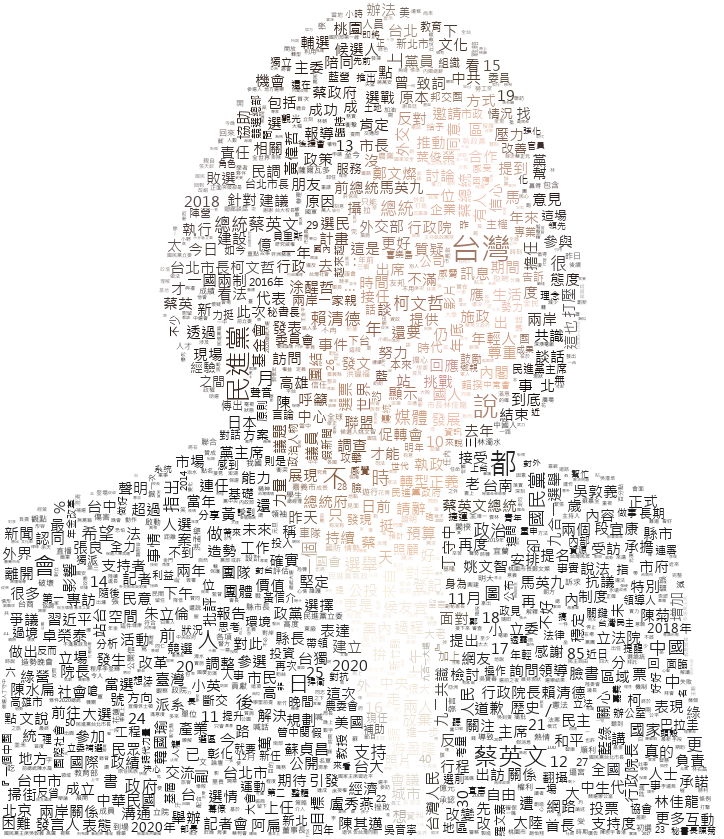

In [57]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()
# plt.imshow(ten_wc, interpolation="bilinear")
# plt.axis("off")
# plt.figure()

In [58]:
'''The most high frequency words that show simultaneously with "蔡英文" '''
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5039), ('民進黨', 3893), ('蔡英文', 3738), ('中國', 2136), ('國民黨', 2021)]

42597


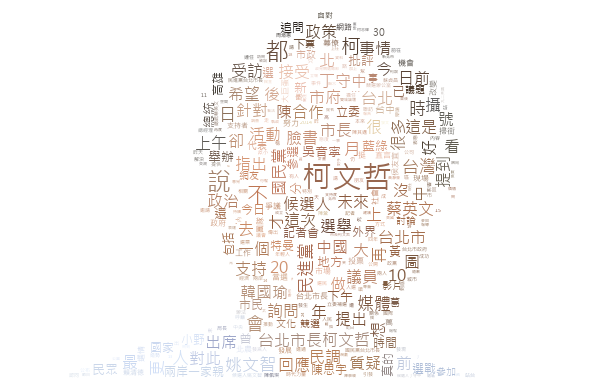

In [60]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [61]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 5)

[('柯文哲', 8153), ('媒體', 2356), ('姚文智', 2120), ('台灣', 2117), ('民進黨', 2107)]

### get date

In [117]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
aall_date = [date[5:] for date in all_date][::-1] #delect the year and asc
dall_date = aall_date[::-1]
date_index = [date_list.index(each_date) for each_date in all_date] #find the frist index of specific day
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)] #how many news in each day
#how many terms in each day
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [74]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-1):
#     print(date_index[i+1])
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [77]:
# 每日詞頻 
# ratio
tf_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [78]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    # the freq. of this word in today's news
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i]) 
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [80]:
wn_by_day['2018-06-07']

{'小組': 1.0,
 '選舉': 4.0,
 '道': 5.0,
 '條例': 3.0,
 '大眾': 2.0,
 '權謀': 1.0,
 '站立': 1.0,
 '走出': 1.0,
 '干涉': 1.0,
 '獲悉': 1.0,
 '各國': 3.0,
 '結束': 1.0,
 '因未': 1.0,
 '看會': 1.0,
 '吳晟': 4.0,
 '妥': 1.0,
 '定期': 3.0,
 '讚': 3.0,
 '北農案': 1.0,
 '穿著': 1.0,
 '對待': 1.0,
 '邱垂政': 1.0,
 '費買': 1.0,
 '35': 1.0,
 '與民眾': 1.0,
 '經駐': 1.0,
 '超過': 1.0,
 '總統府': 1.0,
 '一早': 1.0,
 '作好': 1.0,
 '皇冠': 1.0,
 '一連': 1.0,
 '財團': 1.0,
 '瞭解': 2.0,
 '碧海': 1.0,
 '發出': 1.0,
 '桃捷': 2.0,
 '固定': 1.0,
 '揭露': 1.0,
 '給足': 1.0,
 '下周': 1.0,
 '交通局長': 1.0,
 '找': 1.0,
 '攻防': 1.0,
 '議員': 5.0,
 '談話會': 1.0,
 '會同': 2.0,
 '導演': 3.0,
 '侯友宜': 7.0,
 '水果': 3.0,
 '團體': 1.0,
 '正義': 1.0,
 '新北市議員': 2.0,
 '無良': 1.0,
 '郝龍斌': 2.0,
 '政績': 1.0,
 '指揮部': 1.0,
 '增加': 1.0,
 '嘴': 1.0,
 '怨聲載道': 1.0,
 '隻': 1.0,
 '稱': 5.0,
 '不少': 1.0,
 '桃園機場': 1.0,
 '公務員': 1.0,
 '前': 4.0,
 '遙遠': 1.0,
 '偵辦': 1.0,
 '洪說': 1.0,
 '剛好': 2.0,
 '奕奕': 1.0,
 '宿舍': 1.0,
 '行徑': 2.0,
 '電請': 1.0,
 '新北市長朱立倫': 1.0,
 '建章': 1.0,
 '審查': 3.0,
 '淺水灣': 2.0,
 '建議': 1.0,
 '棄守': 1.0,
 '國民黨': 10.0,
 '專用車': 1.

In [81]:
tf_by_day['2018-06-07']

{'小組': 0.0005417118093174431,
 '選舉': 0.0021668472372697724,
 '道': 0.0027085590465872156,
 '條例': 0.0016251354279523292,
 '大眾': 0.0010834236186348862,
 '權謀': 0.0005417118093174431,
 '站立': 0.0005417118093174431,
 '走出': 0.0005417118093174431,
 '干涉': 0.0005417118093174431,
 '獲悉': 0.0005417118093174431,
 '各國': 0.0016251354279523294,
 '結束': 0.0005417118093174431,
 '因未': 0.0005417118093174431,
 '看會': 0.0005417118093174431,
 '吳晟': 0.0021668472372697724,
 '妥': 0.0005417118093174431,
 '定期': 0.0016251354279523294,
 '讚': 0.0016251354279523292,
 '北農案': 0.0005417118093174431,
 '穿著': 0.0005417118093174431,
 '對待': 0.0005417118093174431,
 '邱垂政': 0.0005417118093174431,
 '費買': 0.0005417118093174431,
 '35': 0.0005417118093174431,
 '與民眾': 0.0005417118093174431,
 '經駐': 0.0005417118093174431,
 '超過': 0.0005417118093174431,
 '總統府': 0.0005417118093174431,
 '一早': 0.0005417118093174431,
 '作好': 0.0005417118093174431,
 '皇冠': 0.0005417118093174431,
 '一連': 0.0005417118093174431,
 '財團': 0.0005417118093174431,
 '瞭解': 0.

In [82]:
occur_by_day['2018-06-07']

{'小組': 0.125,
 '選舉': 0.25,
 '道': 0.25,
 '條例': 0.25,
 '大眾': 0.125,
 '權謀': 0.125,
 '站立': 0.125,
 '走出': 0.125,
 '干涉': 0.125,
 '獲悉': 0.125,
 '各國': 0.125,
 '結束': 0.125,
 '因未': 0.125,
 '看會': 0.125,
 '吳晟': 0.125,
 '妥': 0.125,
 '定期': 0.125,
 '讚': 0.25,
 '北農案': 0.125,
 '穿著': 0.125,
 '對待': 0.125,
 '邱垂政': 0.125,
 '費買': 0.125,
 '35': 0.125,
 '與民眾': 0.125,
 '經駐': 0.125,
 '超過': 0.125,
 '總統府': 0.125,
 '一早': 0.125,
 '作好': 0.125,
 '皇冠': 0.125,
 '一連': 0.125,
 '財團': 0.125,
 '瞭解': 0.125,
 '碧海': 0.125,
 '發出': 0.125,
 '桃捷': 0.125,
 '固定': 0.125,
 '揭露': 0.125,
 '給足': 0.125,
 '下周': 0.125,
 '交通局長': 0.125,
 '找': 0.125,
 '攻防': 0.125,
 '議員': 0.5,
 '談話會': 0.125,
 '會同': 0.125,
 '導演': 0.125,
 '侯友宜': 0.25,
 '水果': 0.125,
 '團體': 0.125,
 '正義': 0.125,
 '新北市議員': 0.125,
 '無良': 0.125,
 '郝龍斌': 0.125,
 '政績': 0.125,
 '指揮部': 0.125,
 '增加': 0.125,
 '嘴': 0.125,
 '怨聲載道': 0.125,
 '隻': 0.125,
 '稱': 0.375,
 '不少': 0.125,
 '桃園機場': 0.125,
 '公務員': 0.125,
 '前': 0.5,
 '遙遠': 0.125,
 '偵辦': 0.125,
 '洪說': 0.125,
 '剛好': 0.125,
 '奕奕': 0.125,
 '宿舍'

In [85]:
df_wn = pd.DataFrame(wn_by_day)
df_wn = df.fillna(0)

df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

### 畫圖

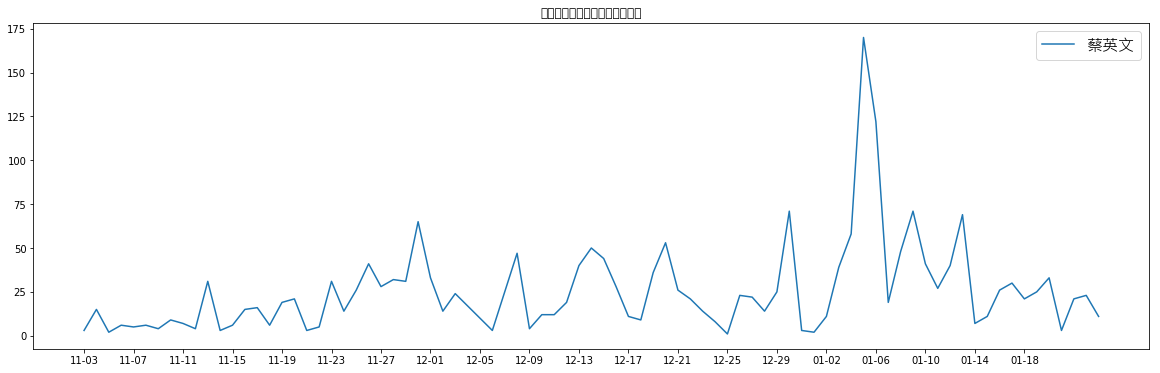

In [96]:
# word times
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.title("蔡英文每天在報紙上出現的次數")
plt.plot(aall_date[147:], df_wn.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.show()

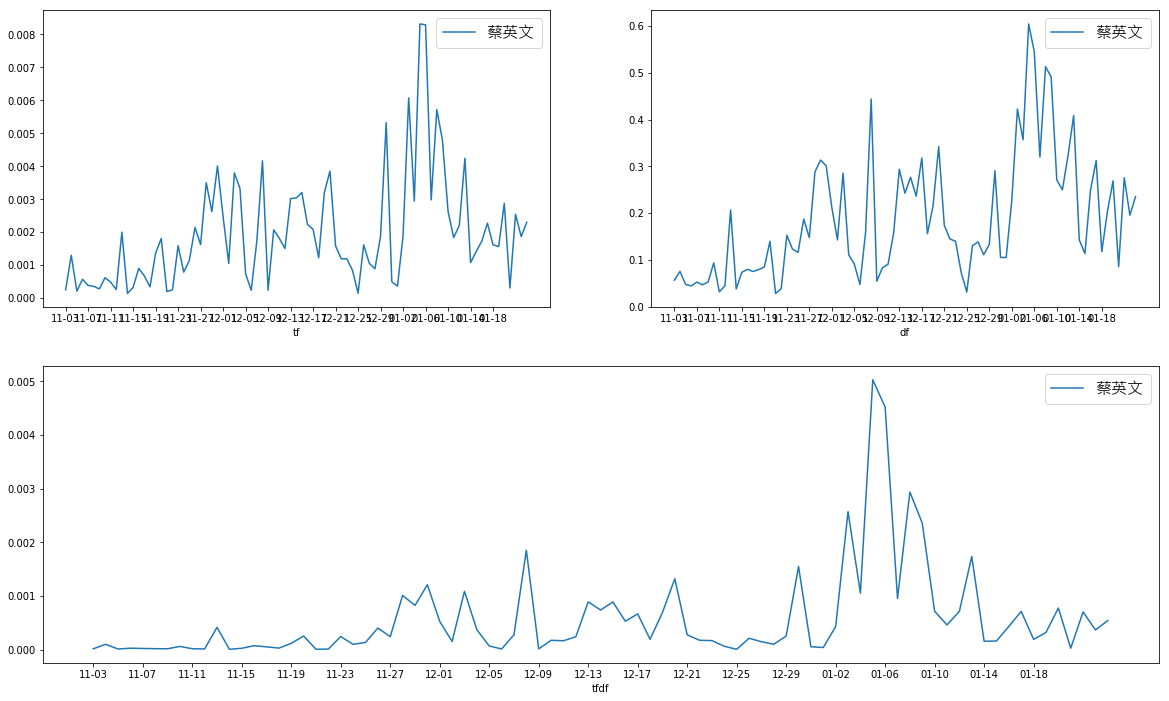

In [100]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='../msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(212)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

# Correct an obivious bug

In [112]:

def plot_tfdf_of_word(word, df_tf, df_occur, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df_tf.columns.get_loc(date_from)
    to_index = df_tf.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25 #the gap is 25 day
    font = font_manager.FontProperties(fname='../msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    dall_date = aall_date[::-1] #desc
    plt.plot(dall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [dall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])

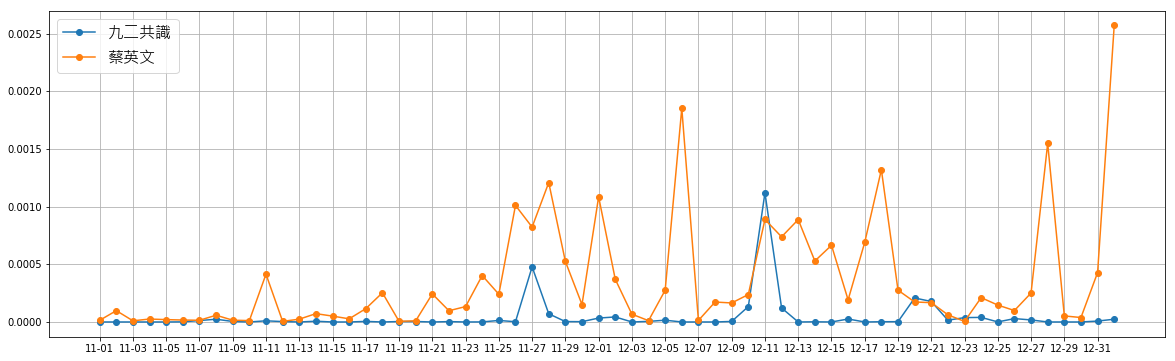

In [113]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('九二共識', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

### 大事件被討論的時間區段與聲量

In [114]:
def get_high_tfdf_date(word, df_tf, df_occur):
    tfdf = get_tfdf(word, df_tf, df_occur) #return the tfdf of this word
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf] #return only high frequency
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))} 
    return tfdf_date

def draw_event(event, i, df_tf, df_occur):
    event_date = get_high_tfdf_date(event, df_tf, df_occur)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])

In [115]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e, df_tf, df_occur) for e in events}
event_high_tfdf_dict['九合一選舉']

{'2018-11-24': 0.0007615105975332301,
 '2018-11-25': 0.0002695716981431267,
 '2018-11-26': 0.0006444655990160315,
 '2018-11-27': 0.00025548759143220696,
 '2018-11-28': 0.0002840320719547916,
 '2018-11-29': 0.0002068233524019918,
 '2018-11-30': 0.00045252281469190716,
 '2018-12-03': 0.0002985498044566326,
 '2018-12-04': 0.0002660853724683512,
 '2018-12-06': 0.0002529358626919602,
 '2018-12-07': 0.0004278074866310161,
 '2018-12-08': 0.00018009451360073768,
 '2018-12-16': 0.00020870246694834399,
 '2019-01-11': 0.00013327592216686143}

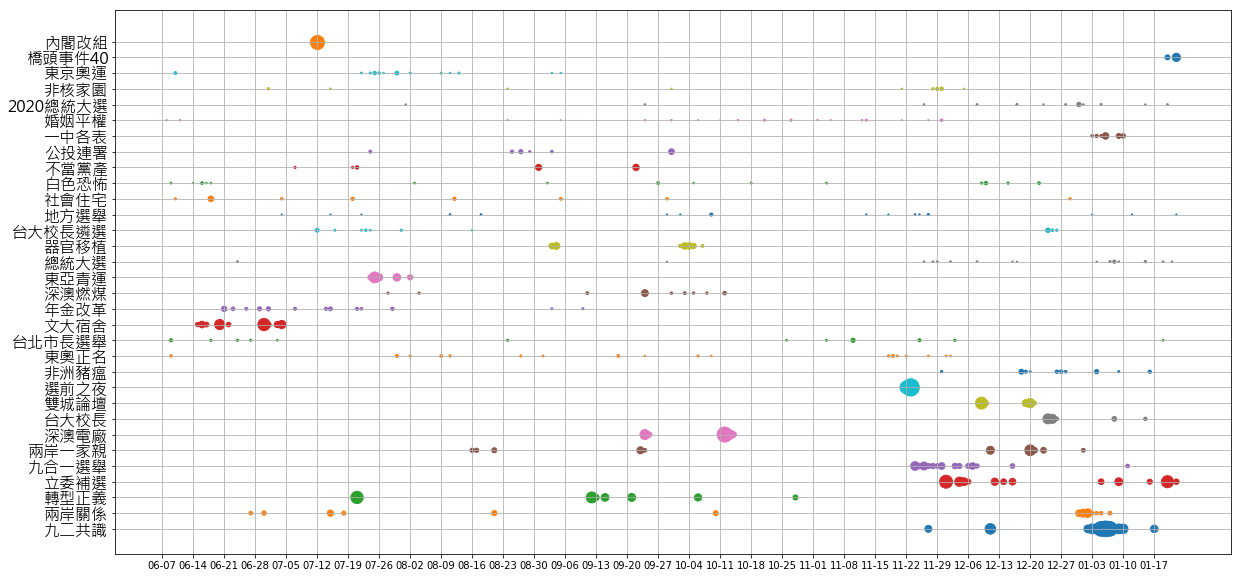

In [118]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i, df_tf, df_occur)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [dall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [30]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
# with open('../data/event_people_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(event_people_dict, j)

In [31]:
pd.DataFrame(event_people_dict).T.head(3)

,丁允恭,丁守中,任美鈴,何孟樺,何志偉,何瑞英,余登發,侯友宜,劉世芳,劉奕霆,...,高思博,高育仁,魏明谷,黃信介,黃偉哲,黃國昌,黃士修,黃敏惠,黃瀞瑩,黃韋鈞
九二共識,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
兩岸關係,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
轉型正義,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN


In [32]:
people_tfdf_dict = {name: list(get_tfdf(name, df_tf, df_occur)) for name in names}

In [33]:
pd.DataFrame(people_tfdf_dict, index=aall_date).T.head(4)

,01-22,01-21,01-20,01-19,01-18,01-17,01-16,01-15,01-14,01-13,...,06-16,06-15,06-14,06-13,06-12,06-11,06-10,06-09,06-08,06-07
柯文哲,0.000135,0.000220,0.000546,0.000000,0.000286,0.000006,0.000234,0.000732,0.000221,0.000109,...,0.000117,0.000233,0.000123,0.000265,0.000259,0.001432,0.001921,0.002752,0.002131,0.001046
韓國瑜,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000706,0.000000,0.000000,...,0.000631,0.000056,0.000043,0.000002,0.001641,0.000389,0.002984,0.006289,0.000092,0.000197
陳其邁,0.000000,0.000118,0.000273,0.000047,0.000000,0.000000,0.000015,0.000029,0.000045,0.000000,...,0.000105,0.000196,0.000078,0.000060,0.000020,0.000017,0.000000,0.000176,0.000000,0.000000
蔡英文,0.000135,0.000152,0.000257,0.000070,0.000034,0.000146,0.000089,0.000118,0.000136,0.000000,...,0.000161,0.000432,0.000711,0.000191,0.000319,0.000775,0.000027,0.000703,0.000366,0.000542


# Part III 視覺化呈現研究結果

In [34]:
# import packages
import math
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime, timedelta
import json

#### Section I 政治事件網路聲量分析

In [35]:
def get_scatter_trace(points_x, points_y, points_size=10, trace_name='', line=False):
    if line:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'lines',
            hoverinfo = 'x+y',
            name
            = trace_name,
            text = points_size,
            yaxis = 'y2',
            line = {
                "color": 'rgba(255, 166, 87, 0.4)'
            }
        )
    else:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'markers' if not line else 'lines',
            marker = {
                'size': points_size
            },
            hoverinfo = 'text+name',
            name = trace_name,
            text = points_size
        )

In [36]:
events = json.loads(open('../data/event_tfdf_dict.json').read())

In [50]:
def sectionI_plot(ori_data, title=''):
    
    # data
    fig_data = []
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for date, tfdf_val in ori_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(ori_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    display(py.iplot(fig, filename='bubble-event'))

In [51]:
sectionI_plot(events)

#### Section II 事件相關人聲量分析

In [44]:
event_people_relation = json.loads(open('../data/event_people_dict.json').read())

In [53]:
def sectionII_plot(event_name, ori_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # data
    fig_data = []
    x, y, size = [], [], []
    for date, tfdf_val in events[event_name].items():
        x.append(datetime.strptime(date, "%Y-%m-%d"))
        y.append(len(ori_data) + 1)
        size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
    fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=event_name))
        
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for day_index, tfdf_val in enumerate(ori_data[name]):
            if tfdf_val != 0:
                x.append(start_date + timedelta(days=day_index))
                y.append(len(ori_data) - index)
                size.append(max(math.log(round(tfdf_val, 2))*10,0)) ## constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='People'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)

    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='event-people'))


In [54]:
event_selector = widgets.Dropdown(
    options=list(events.keys()),
    description='政治事件：'
)
display(event_selector)

def event_change(change):
    top_10_related_people = dict(sorted(event_people_relation[change['new']].items(), key=lambda x: sum(x[1]), reverse=True)[:10])
    sectionII_plot(change['new'], top_10_related_people, event_selector, title=change['new'])

event_change({'new': list(events.keys())[0]})
    
event_selector.observe(event_change, names='value')

Dropdown(description='政治事件：', options=('九二共識', '兩岸關係', '轉型正義', '立委補選', '九合一選舉', '兩岸一家親', '深澳電廠', '台大校長', '雙城論壇…

#### Section III 人物聲量與事件疊圖分析

In [47]:
people = json.loads(open('../data/people_tfdf_dict.json').read())

In [55]:
def sectionIII_plot(people_data, events_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    fig_data = []
    
    # people data
    x, y = [], []
    for day_index, value in enumerate(people_data['tfdf']):
        x.append(start_date + timedelta(days=day_index))
        y.append(value)
    fig_data.append(get_scatter_trace(x, y, line=True))
    
    # event data
    for index, name in enumerate(events_data):
        x, y, size = [], [], []
        for date, tfdf_val in events_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(events_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        ),
        yaxis2=dict(
            title='People Reputation',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    
    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='person-events'))

In [56]:
people_selector = widgets.Dropdown(
    options=list(people.keys()),
    description='政治人物：'
)
display(people_selector)

def people_change(change):
    sectionIII_plot({
        'name': change['new'],
        'tfdf': people[change['new']]
    }, events, people_selector, title='人物與事件聲量圖({})'.format(change['new']))

people_change({'new': list(people.keys())[0]})
    
people_selector.observe(people_change, names='value')


Dropdown(description='政治人物：', options=('柯文哲', '韓國瑜', '陳其邁', '蔡英文', '蘇貞昌', '姚文智', '侯友宜', '丁守中', '賴清德', '馬英九', '…

### Visualization
[Section I 政治事件網路聲量分析](https://plot.ly/~a136489/67)

[Section II 事件相關人聲量分析](https://plot.ly/~a136489/69/#/)

[Section III 人物聲量與事件疊圖分析](https://plot.ly/~a136489/71)
